In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta, date, time
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import pylab
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
pylab.rcParams['figure.figsize'] = (15, 10)

In [2]:
# Сброс ограничений на число выводимых столбцов
pd.set_option('display.max_columns', None)

# Деревья решений

Огромное преимущество деревьев решений в том, что они легко интерпретируемы, понятны человеку.

В основе популярных алгоритмов построения дерева решений лежит принцип жадной максимизации прироста информации – на каждом шаге выбирается тот признак, при разделении по которому прирост информации оказывается наибольшим. Дальше процедура повторяется рекурсивно, пока энтропия не окажется равной нулю или какой-то малой величине (если дерево не подгоняется идеально под обучающую выборку во избежание переобучения). 

Плюсы дерева решений:

- Порождение четких правил классификации, понятных человеку, например, "если возраст < 25 и интерес к мотоциклам, то отказать в кредите". Это свойство называют интерпретируемостью модели;
- Деревья решений могут легко визуализироваться, как сама модель (дерево), так и прогноз для отдельного взятого тестового объекта (путь в дереве);
- Быстрые процессы обучения и прогнозирования;
- Малое число параметров модели;
- Поддержка и числовых, и категориальных признаков.

Минусы:

- У порождения четких правил классификации есть и другая сторона: деревья очень чувствительны к шумам во входных данных, вся модель может кардинально измениться, если немного изменится обучающая выборка (например, если убрать один из признаков или добавить несколько объектов), поэтому и правила классификации могут сильно изменяться, что ухудшает интерпретируемость модели;
- Разделяющая граница, построенная деревом решений, имеет свои ограничения (состоит из гиперплоскостей, перпендикулярных какой-то из координатной оси), и на практике дерево решений по качеству классификации уступает некоторым другим методам.

Рассмотрим пример построения дерева решений на данных о разновидностях цветка ириса:

In [3]:
from google.colab import drive  # если вы выполняете код из среды Google Colab, нужно подключить свой гугл-диск,
drive.mount('/content/drive')   # чтобы можно было оттуда считать файл с данными для этого задания

Mounted at /content/drive


In [ ]:
iris = pd.read_excel('/content/drive/MyDrive/Pyton/iris.xlsx')
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


[]

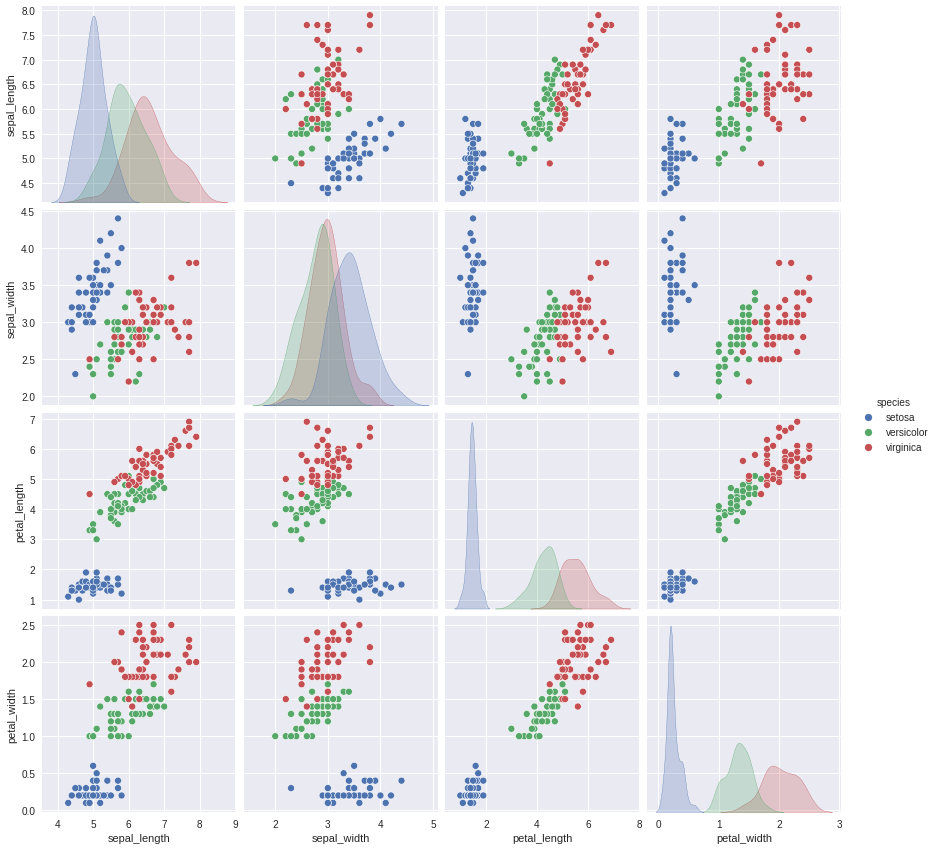

In [ ]:
sns.pairplot(iris, hue="species", height=3)
plt.plot()

[]

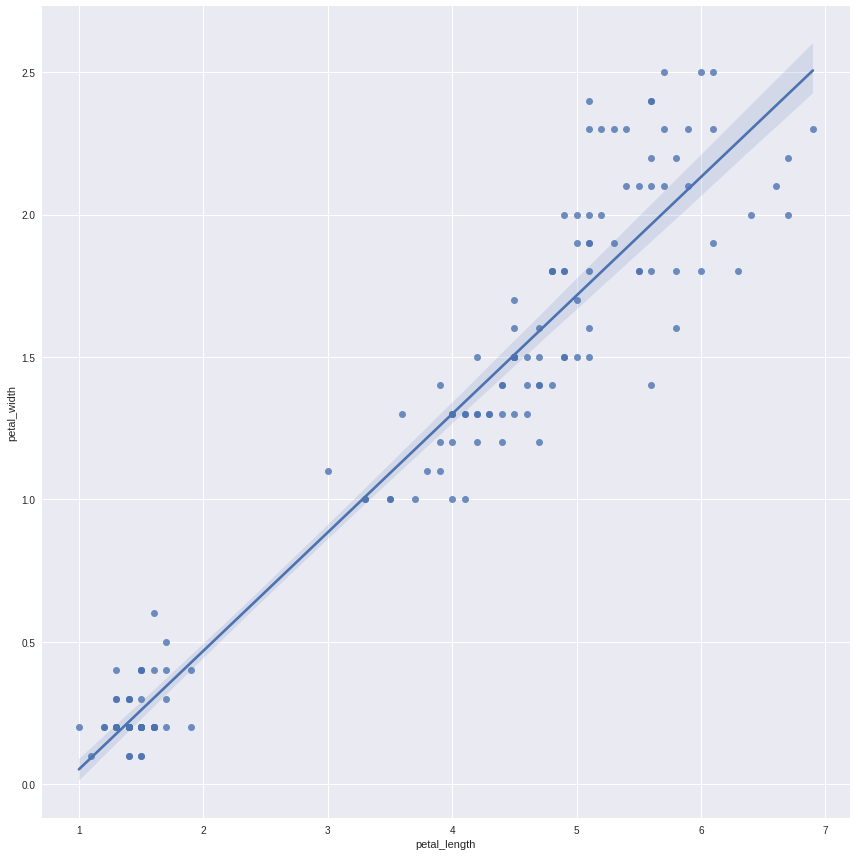

In [ ]:
sns.lmplot(x="petal_length", y="petal_width", data=iris, height=12)
plt.plot()

In [4]:
from sklearn.tree import DecisionTreeClassifier
from IPython.core.display import Image, display
from sklearn.tree import export_graphviz

In [ ]:
y = iris.species
X = iris.drop('species', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
tree = DecisionTreeClassifier(random_state=21,max_depth=3)
tree.fit(X_train_std, y_train)
y_pred = tree.predict(X_test_std)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       1.00      0.80      0.89        15
   virginica       0.77      1.00      0.87        10

    accuracy                           0.92        38
   macro avg       0.92      0.93      0.92        38
weighted avg       0.94      0.92      0.92        38



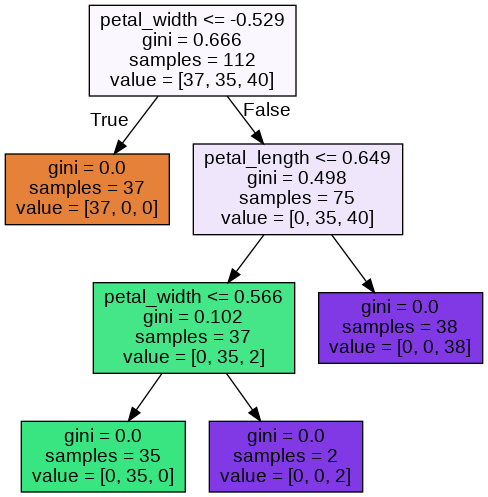

In [ ]:
export_graphviz(tree, feature_names=X.columns , out_file='tree.dot', filled=True)
!dot -Tpng 'tree.dot' -o 'tree.png'
display(Image('tree.png', unconfined=True))

---

# Метод ближайших соседей

Метод ближайших соседей (k Nearest Neighbors, или kNN) — популярный метод классификации. На уровне интуиции суть метода такова: посмотри на соседей, какие преобладают, таков и ты. Формально основой метода является гипотеза компактности: если метрика расстояния между примерами введена достаточно удачно, то схожие примеры гораздо чаще лежат в одном классе, чем в разных.

Для классификации каждого из объектов тестовой выборки необходимо последовательно выполнить следующие операции:

Вычислить расстояние до каждого из объектов обучающей выборки
Отобрать k объектов обучающей выборки, расстояние до которых минимально
Класс классифицируемого объекта — это класс, наиболее часто встречающийся среди k ближайших соседей

Качество классификации методом ближайших соседей зависит от нескольких параметров:

- число соседей;
- метрика расстояния между объектами (часто используются метрика Хэмминга, евклидово расстояние, косинусное расстояние и расстояние Минковского). При использовании большинства метрик значения признаков надо масштабировать. 
- веса соседей (соседи тестового примера могут входить с разными весами, например, чем дальше пример, тем с меньшим коэффициентом учитывается его "голос")

Плюсы метода ближайших соседей:

- Простая реализация;
- Неплохо изучен теоретически;
- Как правило, метод хорош для первого решения задачи;
- Можно адаптировать под нужную задачу выбором метрики или ядра (ядро может задавать операцию сходства для сложных объектов типа графов, а сам подход kNN остается тем же);
- Неплохая интерпретация, можно объяснить, почему тестовый пример был классифицирован именно так.

Минусы:

- Метод считается быстрым в сравнении, например, с композициями алгоритмов, но в реальных задачах, как правило, число соседей, используемых для классификации, будет большим (100-150), и в таком случае алгоритм будет работать не так быстро, как дерево решений;
- Если в наборе данных много признаков, то трудно подобрать подходящие веса и определить, какие признаки не важны для классификации;
- Зависимость от выбранной метрики расстояния между примерами. Выбор по умолчанию евклидового расстояния чаще всего ничем не обоснован. Можно отыскать хорошее решение перебором параметров, но для большого набора данных это отнимает много времени;
- Нет теоретических оснований выбора определенного числа соседей — только перебор (впрочем, чаще всего это верно для всех гиперпараметров всех моделей). В случае малого числа соседей метод чувствителен к выбросам, то есть склонен переобучаться;
- Как правило, плохо работает, когда признаков много, из-за "проклятия размерности". 


In [5]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_std, y_train)
y_pred = knn.predict(X_test_std)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      setosa       1.00      0.92      0.96        13
  versicolor       0.87      0.87      0.87        15
   virginica       0.82      0.90      0.86        10

    accuracy                           0.89        38
   macro avg       0.89      0.90      0.89        38
weighted avg       0.90      0.89      0.90        38



---

# Задание

В файлах *iCafe 2 month.xlsx* и *iCafe 15 days.xlsx* содержатся данные для обучения и тестирования классификаторов. Требуется построить три классификатора:

- На основе логистической регрессии;
- На основе дерева решений;
- На основе метода ближайшего соседа.

Основная цель - это достичь значение $F_1$ метрики на выборке 15 дней не менее чем:
- 0.86 для логистической регрессии;
- 0.9 для дерева решений;
- 0.89 для метода ближайшего соседа.

Вам будут даны небольшие подсказки в виде преобразования данных, но основные действия по преобразованию и выбору
признаков для обучения остаются за вами.

Так же, необходимо провести анализ и сделать выводы о результатах, при изменении параметров:
- ***max_depth***, при обучении дерева решений;
- ***n_neighbors***, при обучении классификатора методом ближайшего соседа.

Опишите эти выводы текстом в блокноте с решением. При каких значениях гиперпараметров модели становятся максимально переобученными? Какова область значений гиперпараметров, в которой они могут повлиять на качество обучения модели?

---

Подсказки:

# Просмотр таблиц

In [6]:
"""Получение данных для обучения (2 месяца) и тестовых данных (15 дней)"""
df_2 = pd.read_excel('/content/drive/MyDrive/Pyton/iCafe 2 month.xlsx')
df_15 = pd.read_excel('/content/drive/MyDrive/Pyton/iCafe 15 days.xlsx')

In [ ]:
"просмотр df"
df_2

In [ ]:
"просмотр df_15"
df_15

---

Просмотр данных указывает нам на две проблемы:

1. Столбец *Order_date_time* содержит одновременно информацию о дате и времени. Для удобства последующего анализа нам необходимо разделить данные столбца на столбец даты и столбец времени.
2. В *df_15* появились значения **NaN** (сокращение от Not a Number) — это специальное значение с плавающей точкой, распознаваемое всеми системами, которые используют стандартное представление IEEE с плавающей точкой. Это означает, что данные отсутствуют. Для дальнейшего анализа нам необходимо каким-либо образом обработать отсутствующие значения (либо удалить строки, либо заполнить значениями).

Решим первую проблему:

#Разделим данные по дате на дату и время

In [ ]:
"""Разбиение даты и времени на отдельные столбцы"""
def share_date_time(df, sep = ' '):
    X = df.Order_date_time.str.split(pat = sep, expand = True)
    df['Order_date'], df['Order_time'] = X[0], X[1]
    return df

df_2 = share_date_time(df_2)
df_2

In [ ]:
df_15 = share_date_time(df_15)
df_15

#Работа с NaN

Теперь займемся решением второй проблемы. Для начала посмотрим информацию от том, как заполнены столбцы датафреймов:

In [11]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20791 entries, 0 to 20790
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Order_date_time  20791 non-null  object
 1   Delivery_time    20791 non-null  int64 
 2   Office           20791 non-null  int64 
 3   Rain             20791 non-null  int64 
 4   Order_date       20791 non-null  object
 5   Order_time       20791 non-null  object
dtypes: int64(3), object(3)
memory usage: 974.7+ KB


---

В данных для обучения пропусков нет.

In [12]:
df_15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_date_time  5473 non-null   object 
 1   Delivery_time    5473 non-null   int64  
 2   Office           5473 non-null   int64  
 3   Rain             4516 non-null   float64
 4   Order_date       5473 non-null   object 
 5   Order_time       5473 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 256.7+ KB


---

В тестовых данных пропуски содержатся только в столбце Rain. Показать часть датафрейма с пропусками в столбце можно так:

In [ ]:
df_15[pd.isnull(df_15.Rain)]

---

Посмотрим, на какие даты приходятся пропуски:

In [14]:
df_15.Order_date[pd.isnull(df_15.Rain)].unique()

array(['2020-11-13', '2020-11-14', '2020-11-15'], dtype=object)

---

Получается, что три последних дня тестового датасета не имеют информации о дожде. Для того, чтобы заполнить отсутствующие данные, вам потребуется дополнительная информация: 
1. Определение дня недели
2. Выявление влияния дождя на количество заказов по дням недели:
    - Визуальный анализ распределения заказов по дням недели;
    - Табличный анализ заказов по дням недели при наличии и отсутствии дождя.

In [ ]:
"""Определение дня недели, 1 - понедельник"""
def day_of_the_week(df):
    df['day_of_the_week'] = [datetime.isoweekday(datetime.strptime(j, '%Y-%m-%d %H:%M:%S')) 
                             for j in df.Order_date_time]
    return df

df_2 = day_of_the_week(df_2)
df_15 = day_of_the_week(df_15)
df_2

In [ ]:
"""Преобразование времени заказа в секунды требуется для построения графиков (и для классификаторов)"""
def time_to_sec(df):
    df['Order_time_sec'] = pd.to_timedelta(df.Order_time)//np.timedelta64(1,'s')
    return df

df_2 = time_to_sec(df_2)
df_15 = time_to_sec(df_15)
df_2

In [ ]:
"""Графики распределения заказов по дням недели"""
weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i, j in enumerate(weekday):
    dff = df_2[df_2.day_of_the_week == i+1]
    plt.scatter(dff.Order_time_sec[dff.Office == 1], dff.Delivery_time[dff.Office == 1], 
                marker = '.', color = 'red')
    plt.scatter(dff.Order_time_sec[dff.Office == 0], dff.Delivery_time[dff.Office == 0], marker = '.')
    plt.title(j)
    plt.legend(['В офис', 'На дом'])
    plt.xlabel('Время поступления заказа (Order_time_sec)')
    plt.ylabel('Время доставки заказа (Delivery_time)')
    plt.show()

---

Визуальный анализ не сильно помог, разве что мы наблюдаем снижение количества заказов из офиса в субботу и воскресенье.

Построим таблицу с аналитической информацией. Для каждого дня недели мы хотим получить аналитическую информацию об общем количестве заказов, количестве заказов в офис и количестве заказов на дом. Информация будет о среднем, максимальном и минимальном количестве заказов при условии наличия и отсутствия дождя:

In [ ]:
"""Формирование названий строк и столбцов таблицы"""

mltindex = pd.DataFrame(columns = [['Monday', 'Monday', 'Monday', 'Tuesday', 'Tuesday', 'Tuesday', 'Wednesday', 
                                     'Wednesday', 'Wednesday', 'Thursday', 'Thursday', 'Thursday', 'Friday', 
                                     'Friday', 'Friday', 'Saturday', 'Saturday', 'Saturday', 'Sunday', 'Sunday', 
                                     'Sunday'], ['total', 'to_office', 'to_home']*7],
                          index = [['rain', 'rain', 'rain', 'no_rain', 'no_rain', 'no_rain'],
                                   ['mean_order', 'max_order', 'min_order']*2])
mltindex

In [19]:
"""Заполнение таблицы значениями"""

def mean_max_min(df):
    s = []
    for j in df.Order_date.unique():
        s.append(len(df[df.Order_date == j]))
    if len(s) == 0:
        return np.nan, np.nan, np.nan
    return int(round(sum(s)/len(s),0)), max(s), min(s)

def analysis(df, col):
    weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df_day = df[df.day_of_the_week == weekday.index(col[0])+1]
    if col[1] == 'to_office':
        df_day = df_day[df_day.Office == 1]
    elif col[1] == 'to_home':
        df_day = df_day[df_day.Office == 0]
    c = []
    c.extend(mean_max_min(df_day[df_day.Rain == 1]))
    c.extend(mean_max_min(df_day[df_day.Rain == 0]))
    return c
    
for j in mltindex.columns:
    mltindex[j] = analysis(df_2, j)
    
mltindex

Monday                   Tuesday                    \
                    total to_office to_home   total to_office to_home   
rain    mean_order    435       230     206     446       226     221   
        max_order     452       245     207     458       227     234   
        min_order     418       214     204     435       224     208   
no_rain mean_order    351       227     123     373       239     134   
        max_order     374       244     130     387       250     144   
        min_order     328       208     119     346       213     129   

                   Wednesday                   Thursday                    \
                       total to_office to_home    total to_office to_home   
rain    mean_order       452       235     217      457       234     222   
        max_order        482       255     227      481       250     243   
        min_order        421       215     206      426       212     213   
no_rain mean_order       357       233     124      352       222     130   
        max_order        367       240     136      364       237     137   
        min_order        348       226     116      343       211     121   

                   Friday                   Saturday                   Sunday  \
                    total to_office to_home    total to_office to_home  total   
rain    mean_order    410       233     177      314        78     236    310   
        max_order     426       247     190      325        80     245    324   
        min_order     399       223     168      304        76     228    295   
no_rain mean_order    326       222     104      198        73     125    202   
        max_order     348       237     111      219        85     141    215   
        min_order     311       214      91      182        58     111    190   

                                      
                   to_office to_home  
rain    mean_order        84     225  
        max_order         89     244  
        min_order         80     206  
no_rain mean_order        69     133  
        max_order         73     150  
        min_order         65     121

---

Проанализировав полученную таблицу вы сможете заполнить пропущенные значения в тестовом датасете.

---

Визуальный анализ показал, что день недели может повлиять на классификацию заказа. В текущем представлении данные о дне недели нельзя использовать при обучении классификатора. Их можно преобразовать так же как и время через синус и косинус, а можно создать столбцы дней недели и проставить нули и единицы, свидетельствующие о принадлежности заказа к соответствующему дню недели:

In [20]:
# Посчитаем количество заказов в последние три дня, чтобы определить, был ли дождь ['2020-11-13', '2020-11-14', '2020-11-15']
print('friday ',len(df_15[df_15['Order_date'] == '2020-11-13']))
print('saturday ',len(df_15[df_15['Order_date'] == '2020-11-14']))
print('sunday ',len(df_15[df_15['Order_date'] == '2020-11-15']))

friday  334
saturday  307
sunday  316


сравниваем количество заказов с средним количеством по этому дню недели и смотрим, к какому числу ближе. Например, для пятницы у нас 334 заказа, а в среднем в дождь 410, без дождя - 326.
Вывод: в пятницу дождя не было, в субботу и воскресенье был.

In [21]:
# Заполним таблицу нужными значениями

#data = data.replace({'День недели':{0:'Понедельник', 1:'Вторник', 2:'Среда', 3:'Четверг', 4:'Пятница', 5:'Суббота', 6:'Воскресенье'}})
df_15.loc[(df_15.Order_date == '2020-11-13'), ('Rain')] = 0.0
df_15.loc[(df_15.Order_date == '2020-11-14'), ('Rain')] = 1.0
df_15.loc[(df_15.Order_date == '2020-11-15'), ('Rain')] = 1.0
df_15

,Order_date_time,Delivery_time,Office,Rain,Order_date,Order_time,day_of_the_week,Order_time_sec
0,2020-11-01 0:02:37,3,1,0.0,2020-11-01,0:02:37,7,157
1,2020-11-01 0:09:50,15,0,0.0,2020-11-01,0:09:50,7,590
2,2020-11-01 0:10:35,7,1,0.0,2020-11-01,0:10:35,7,635
3,2020-11-01 0:13:08,8,1,0.0,2020-11-01,0:13:08,7,788
4,2020-11-01 0:22:38,7,1,0.0,2020-11-01,0:22:38,7,1358
...,...,...,...,...,...,...,...,...
5468,2020-11-15 23:36:56,6,1,1.0,2020-11-15,23:36:56,7,85016
5469,2020-11-15 23:43:57,8,1,1.0,2020-11-15,23:43:57,7,85437
5470,2020-11-15 23:45:35,6,1,1.0,2020-11-15,23:45:35,7,85535
5471,2020-11-15 23:49:25,3,1,1.0,2020-11-15,23:49:25,7,85765


In [22]:
# Убедимся, что неизвестных значений больше нет
df_15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_date_time  5473 non-null   object 
 1   Delivery_time    5473 non-null   int64  
 2   Office           5473 non-null   int64  
 3   Rain             5473 non-null   float64
 4   Order_date       5473 non-null   object 
 5   Order_time       5473 non-null   object 
 6   day_of_the_week  5473 non-null   int64  
 7   Order_time_sec   5473 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 342.2+ KB


#Применим логистическую регрессию

In [23]:
df_2_lr = df_2.copy()
df_15_lr = df_15.copy()

In [25]:
# Сделаем логистическую регрессию на неизмененных данных (только заполнены NaN)

def Processing_results(sc, lr, df, target, attribute_name, name, add_schedule = []):
    X_std = sc.transform(df[attribute_name])
    new_col_name = []
    for i, col_name in enumerate(attribute_name):
        s = col_name + '_std_' + name
        df[s] = X_std[:,i]
        new_col_name.append(s)
    y_pred = 'y_pred_' + name
    Correct = 'Correct_' + name
    df[y_pred] = lr.predict(X_std)
    df[Correct] = df.Office == df[y_pred]
    print(classification_report(df.Office, df[y_pred]))
    return df

def log_reg(y,X):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

  sc = StandardScaler()
  sc.fit(X_train)                                  # Находим среднее и стандартное отклонение обучающей выборки
  X_train_std = sc.transform(X_train)              # Преобразовываем обучающую выборку
  X_test_std = sc.transform(X_test)                # Преобразовываем тестовую выборку

  """Формируем классификатор с помощью LogisticRegression. Коэффициенты уравнения логистической регрессии находятся
    на обучающей выборке, затем с помощью найденного уравнения предсказывается класс объекта на тестовой выборке"""
  lr = LogisticRegression(random_state=21)
  lr.fit(X_train_std, y_train)                     # Находим коэффициенты уравнения логистической регрессии
  y_pred = lr.predict(X_test_std)                  # Определяем класс на значениях тестовых данных
  return sc, lr

#Применяем на учебной выборке
y = 'Office'
x = ['Order_time_sec', 'Delivery_time']
sc_delta, lr_delta = log_reg(df_2_lr[y], df_2_lr[x])
df_2_lr = Processing_results(sc_delta, lr_delta, df_2_lr, y, x, 'delta', [x])

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      9389
           1       0.87      0.88      0.87     11402

    accuracy                           0.86     20791
   macro avg       0.86      0.86      0.86     20791
weighted avg       0.86      0.86      0.86     20791



In [26]:
#Применяем на тестовой выборке
y = 'Office'
x = ['Order_time_sec', 'Delivery_time']
sc_delta, lr_delta = log_reg(df_15_lr[y], df_15_lr[x])
df_15_lr = Processing_results(sc_delta, lr_delta, df_15_lr, y, x, 'delta', [x])

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      2767
           1       0.86      0.85      0.86      2706

    accuracy                           0.86      5473
   macro avg       0.86      0.86      0.86      5473
weighted avg       0.86      0.86      0.86      5473



Получили результат, который нас удовлетворяет.

# Применим дерево выбора

План:
1. Попробовать построить дерево для исходной таблицы.
2. Попробовать менять глубину.
3. Добавить weekday
4. Попробовать менять глубину.
5. Попробовать разложить дату на синус и косинус.
6. Попробовать менять глубину.
7. Построить график ошибок по дням недели. Проанализировать.

In [28]:
# Скопируем данные, чтобы после применения метода не менялись исходные (в логистической регрессии мы сделали предобраблтку, которая нам понадобится для всех методов)
df_2_tc = df_2.copy()
df_15_tc = df_15.copy()
df_2_tc

,Order_date_time,Delivery_time,Office,Rain,Order_date,Order_time,day_of_the_week,Order_time_sec
0,2020-09-01 0:15:10,10,1,1,2020-09-01,0:15:10,2,910
1,2020-09-01 0:17:38,5,1,1,2020-09-01,0:17:38,2,1058
2,2020-09-01 0:20:23,17,1,1,2020-09-01,0:20:23,2,1223
3,2020-09-01 0:29:52,12,0,1,2020-09-01,0:29:52,2,1792
4,2020-09-01 0:32:52,9,1,1,2020-09-01,0:32:52,2,1972
...,...,...,...,...,...,...,...,...
20786,2020-10-31 23:28:08,4,1,1,2020-10-31,23:28:08,6,84488
20787,2020-10-31 23:39:56,10,1,1,2020-10-31,23:39:56,6,85196
20788,2020-10-31 23:43:11,9,1,1,2020-10-31,23:43:11,6,85391
20789,2020-10-31 23:47:56,9,1,1,2020-10-31,23:47:56,6,85676


In [29]:
# Уберем лишние столбцы для модели
X = df_2_tc.drop(['Order_date_time', 'Office', 'Order_date', 'Order_time', ], axis=1)
X

,Delivery_time,Rain,day_of_the_week,Order_time_sec
0,10,1,2,910
1,5,1,2,1058
2,17,1,2,1223
3,12,1,2,1792
4,9,1,2,1972
...,...,...,...,...
20786,4,1,6,84488
20787,10,1,6,85196
20788,9,1,6,85391
20789,9,1,6,85676


In [30]:
# Строим дерево глубина 3

y = df_2_tc.Office
X = df_2_tc.drop(['Order_date_time', 'Office', 'Order_date', 'Order_time', ], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
tree = DecisionTreeClassifier(random_state=21,max_depth=3)
tree.fit(X_train_std, y_train)
y_pred = tree.predict(X_test_std)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      2332
           1       0.90      0.91      0.90      2866

    accuracy                           0.89      5198
   macro avg       0.89      0.89      0.89      5198
weighted avg       0.89      0.89      0.89      5198



In [31]:
# Хороший результат, пробуем на тестовом датасете

X_15 = df_15_tc.copy()

X_15 = X_15.drop(['Order_date_time', 'Office', 'Order_date', 'Order_time'], axis=1)

sc.fit(X_15)
X_15_std = sc.transform(X_15)

y_pred_test = tree.predict(X_15_std)

print('Глубина = ', 3, classification_report(df_15_tc.Office, y_pred_test))

Глубина =  3               precision    recall  f1-score   support

           0       0.89      0.89      0.89      2767
           1       0.89      0.89      0.89      2706

    accuracy                           0.89      5473
   macro avg       0.89      0.89      0.89      5473
weighted avg       0.89      0.89      0.89      5473



In [36]:
# Строим дерево глубина 4

tree = DecisionTreeClassifier(random_state=21,max_depth=4)
tree.fit(X_train_std, y_train)
y_pred = tree.predict(X_test_std)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      2332
           1       0.95      0.88      0.92      2866

    accuracy                           0.91      5198
   macro avg       0.91      0.91      0.91      5198
weighted avg       0.91      0.91      0.91      5198



In [37]:
# Хороший результат, пробуем на тестовом датасете

X_15 = df_15_tc.copy()

X_15 = X_15.drop(['Order_date_time', 'Office', 'Order_date', 'Order_time'], axis=1)

sc.fit(X_15)
X_15_std = sc.transform(X_15)

y_pred_test = tree.predict(X_15_std)

print('Глубина = ', 3, classification_report(df_15_tc.Office, y_pred_test))

Глубина =  3               precision    recall  f1-score   support

           0       0.76      0.93      0.84      2767
           1       0.91      0.70      0.79      2706

    accuracy                           0.81      5473
   macro avg       0.83      0.81      0.81      5473
weighted avg       0.83      0.81      0.81      5473



Пока результат на тестовом датасете недостаточно хороший, лучшая глубина - 3. При увеличении глубины происходит ухудшение результата - переобучение.

In [38]:
# Добавим столбец со значением выходной/рабочий

X_1 = X.copy()
X_1['weekend'] = 0
X_1.loc[(X.day_of_the_week > 5), 'weekend'] = 1
X_1


,Delivery_time,Rain,day_of_the_week,Order_time_sec,weekend
0,10,1,2,910,0
1,5,1,2,1058,0
2,17,1,2,1223,0
3,12,1,2,1792,0
4,9,1,2,1972,0
...,...,...,...,...,...
20786,4,1,6,84488,1
20787,10,1,6,85196,1
20788,9,1,6,85391,1
20789,9,1,6,85676,1


In [45]:
# Строим дерево, пробуем разные варианты, получаем, что лучший результат дает глубина 3

y = df_2_tc.Office
X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.25, random_state=21)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
tree = DecisionTreeClassifier(random_state=21,max_depth=3)
tree.fit(X_train_std, y_train)
y_pred = tree.predict(X_test_std)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      2332
           1       0.90      0.91      0.90      2866

    accuracy                           0.89      5198
   macro avg       0.89      0.89      0.89      5198
weighted avg       0.89      0.89      0.89      5198



In [46]:
# Пробуем на тестовом датасете

X_15['weekend'] = 0
X_15.loc[(X.day_of_the_week > 5), 'weekend'] = 1

sc.fit(X_15)
X_15_std = sc.transform(X_15)

y_pred_test = tree.predict(X_15_std)

print(classification_report(df_15_tc.Office, y_pred_test))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      2767
           1       0.89      0.89      0.89      2706

    accuracy                           0.89      5473
   macro avg       0.89      0.89      0.89      5473
weighted avg       0.89      0.89      0.89      5473



Результат не улучшился

In [47]:
# Сделаем сдвиг времени
def time_change(df):
  df['Order_time_sec_delta'] = (df['Order_time_sec'] + 24 * 60 * 60 - 80000) % 86400
  return df

X_1 = time_change(X_1)
X_1 = X_1.drop(['Order_time_sec'], axis=1)

X_15 = time_change(X_15)
X_15 = X_15.drop(['Order_time_sec'], axis=1)


In [54]:
# Строим дерево глубина 3

y = df_2_tc.Office
X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.25, random_state=21)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
tree = DecisionTreeClassifier(random_state=21,max_depth=3)
tree.fit(X_train_std, y_train)
y_pred = tree.predict(X_test_std)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88      2332
           1       0.89      0.94      0.91      2866

    accuracy                           0.90      5198
   macro avg       0.90      0.89      0.90      5198
weighted avg       0.90      0.90      0.90      5198



In [55]:
# Пробуем на тестовом датасете

sc.fit(X_15)
X_15_std = sc.transform(X_15)

y_pred_test = tree.predict(X_15_std)

print(classification_report(df_15_tc.Office, y_pred_test))
print(X_15)

              precision    recall  f1-score   support

           0       0.91      0.85      0.88      2767
           1       0.86      0.91      0.88      2706

    accuracy                           0.88      5473
   macro avg       0.88      0.88      0.88      5473
weighted avg       0.88      0.88      0.88      5473

      Delivery_time  Rain  day_of_the_week  weekend  Order_time_sec_delta
0                 3   0.0                7        0                  6557
1                15   0.0                7        0                  6990
2                 7   0.0                7        0                  7035
3                 8   0.0                7        0                  7188
4                 7   0.0                7        0                  7758
...             ...   ...              ...      ...                   ...
5468              6   1.0                7        0                  5016
5469              8   1.0                7        0                  5437
5470   

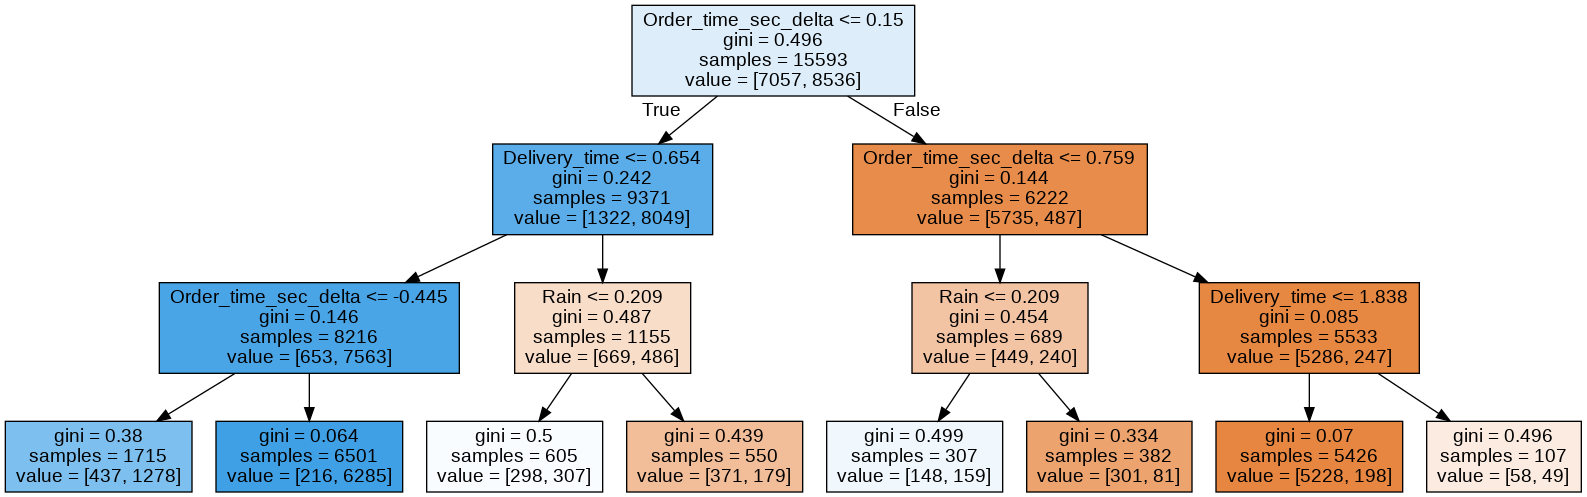

In [56]:
# Выведем дерево решений

export_graphviz(tree, feature_names=X_15.columns , out_file='tree.dot', filled=True)
!dot -Tpng 'tree.dot' -o 'tree.png'
display(Image('tree.png', unconfined=True))

# Применим тригонометрическое разложение

In [58]:
# Добавили новые фичи: разложили время на синус и косинус

X_1['Order_sin'] = np.sin(X_1.Order_time_sec_delta*math.pi/43200)
X_1['Order_cos'] = np.cos(X_1.Order_time_sec_delta*math.pi/43200)

X_15['Order_sin'] = np.sin(X_15.Order_time_sec_delta*math.pi/43200)
X_15['Order_cos'] = np.cos(X_15.Order_time_sec_delta*math.pi/43200)


In [69]:
# Строим дерево, подбираем глубину. Глубина 5 дает нужный результат. Увеличение глубины ведет к переобучению.

y = df_2_tc.Office
X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.25, random_state=21)
#sc = StandardScaler()
#sc.fit(X_train)
#X_train_std = sc.transform(X_train)
#X_test_std = sc.transform(X_test)
tree = DecisionTreeClassifier(random_state=21,max_depth=5)
tree.fit(X_train, y_train) #tree.fit(X_train_std, y_train)
y_pred = tree.predict(X_test) #y_pred = tree.predict(X_test_std)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      2332
           1       0.93      0.90      0.92      2866

    accuracy                           0.91      5198
   macro avg       0.91      0.91      0.91      5198
weighted avg       0.91      0.91      0.91      5198



In [70]:
# Проверим обученную модель на тестовой таблице (df_15)

#sc.fit(X_15)
#X_15_std = sc.transform(X_15)

y_pred_test = tree.predict(X_15) #y_pred_test = tree.predict(X_15_std)

print(classification_report(df_15_tc.Office, y_pred_test))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      2767
           1       0.91      0.87      0.89      2706

    accuracy                           0.90      5473
   macro avg       0.90      0.90      0.90      5473
weighted avg       0.90      0.90      0.90      5473



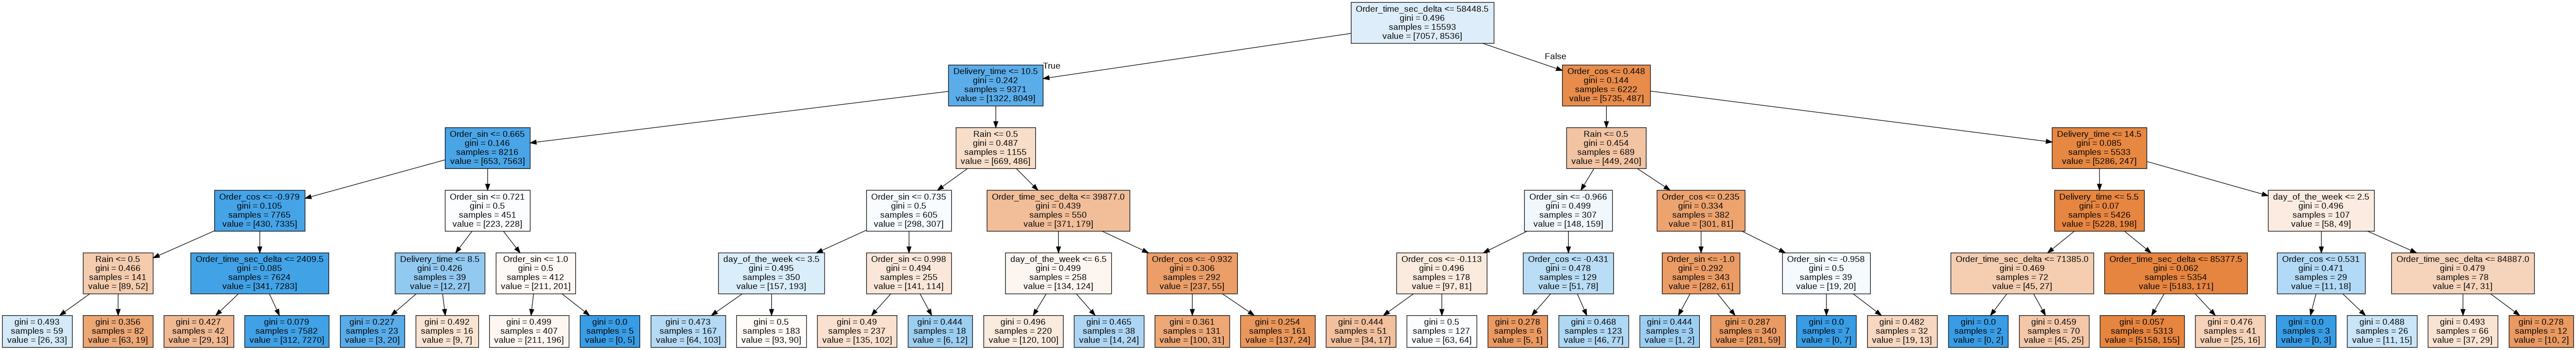

In [65]:
# Построим график дерева

export_graphviz(tree, feature_names=X_15.columns , out_file='tree.dot', filled=True)
!dot -Tpng 'tree.dot' -o 'tree.png'
display(Image('tree.png', unconfined=True))

В дереве решений глубина меньше трех давала всегда плохой результат, увеличение глубины выше оптимальной вело к переобучению. Итоговая оптимальная глубина 5.

# Метод ближайших соседей

In [71]:
df_2_knn = df_2.copy()
df_15_knn = df_15.copy()

In [72]:
# Уберем лишние столбцы для модели

knn_2 = df_2_knn.drop(['Order_date_time', 'Office', 'Order_date', 'Order_time', ], axis=1)
knn_15 = df_15_knn.drop(['Order_date_time', 'Office', 'Order_date', 'Order_time', ], axis=1)

In [78]:
knn_2

,Delivery_time,Rain,day_of_the_week,Order_time_sec_delta
0,10,1,2,7310
1,5,1,2,7458
2,17,1,2,7623
3,12,1,2,8192
4,9,1,2,8372
...,...,...,...,...
20786,4,1,6,4488
20787,10,1,6,5196
20788,9,1,6,5391
20789,9,1,6,5676


In [79]:
# Разделим на тренировочную и тестовую выборки

y = df_2_knn.Office
X_train, X_test, y_train, y_test = train_test_split(knn_2, y, test_size=0.25, random_state=21)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [80]:
# Применим метод

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_std, y_train)
y_pred = knn.predict(X_test_std)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      2332
           1       0.91      0.92      0.91      2866

    accuracy                           0.90      5198
   macro avg       0.90      0.90      0.90      5198
weighted avg       0.90      0.90      0.90      5198



In [81]:
# Пробуем на тестовом датасете

sc.fit(knn_15)
knn_15_std = sc.transform(knn_15)

y_pred_test = knn.predict(knn_15_std)

print(classification_report(df_15_knn.Office, y_pred_test))



              precision    recall  f1-score   support

           0       0.88      0.89      0.89      2767
           1       0.89      0.88      0.88      2706

    accuracy                           0.89      5473
   macro avg       0.89      0.89      0.89      5473
weighted avg       0.89      0.89      0.89      5473



Получили удовлетворяющий нас результат. Потестируем на переобучение.

In [82]:
# Попробуем другое количество соседей

knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train_std, y_train)
y_pred = knn.predict(X_test_std)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      2332
           1       0.93      0.88      0.91      2866

    accuracy                           0.90      5198
   macro avg       0.90      0.90      0.90      5198
weighted avg       0.90      0.90      0.90      5198



In [83]:
# Пробуем на тестовом датасете

sc.fit(knn_15)
knn_15_std = sc.transform(knn_15)

y_pred_test = knn.predict(knn_15_std)

print(classification_report(df_15_knn.Office, y_pred_test))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      2767
           1       0.91      0.84      0.87      2706

    accuracy                           0.88      5473
   macro avg       0.88      0.88      0.88      5473
weighted avg       0.88      0.88      0.88      5473



С 5 до 34 соседей результат наилучший

Меньше трех соседей результат максимально переобученный